In [1]:
from wotan import flatten
import numpy as np
from nuance.utils import transit
import tinygp
import jax
import matplotlib.pyplot as plt
jax.config.update("jax_enable_x64", True)
import sys
sys.path.append("./lib")
sys.path.append("../lib")
from utils import white_red

seed = 42

/Users/lgrcia/code/nuance/nuance/nuance.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# Simulate light curve
# --------------------
np.random.seed(seed)
# transit
time = np.linspace(0, 3, 1000)
dur = 0.1
depth = 0.8e-2
n = dur/np.median(np.diff(time))
signal = transit(time, time.mean(), dur, depth, c=10) + 1.

# white noise
wsigma = 1.5e-3
white_noise = np.random.normal(0, wsigma, len(time))
flux = white_noise + signal

In [3]:
# Simulate variability
# --------------------
lightcurves = []
variabilities = []
gps = []
cond_gps = []

periods = [1000., 1., 0.2, 0.1, 0.04]
amps = [0., 1e-2, 1e-2, 1e-2, 5e-3]

for i, (period, amp) in enumerate(zip(periods, amps)):
    Q = 10.
    w0 = 1/period
    S0 = amp

    var_kernel = tinygp.kernels.quasisep.SHO(w0, Q, S0)
    gp = tinygp.GaussianProcess(var_kernel, time, mean=0.)
    cond_gp = tinygp.GaussianProcess(var_kernel, time, mean=0., diag=wsigma**2)
    variability = gp.sample(jax.random.PRNGKey(seed))
    variability -= np.median(variability)
    flux = white_noise + signal + variability
    lightcurves.append(flux)
    variabilities.append(variability)
    gps.append(gp)
    cond_gps.append(cond_gp)

In [41]:
# Trends and SNR
# -------------
wotan_trend_snr = []
gp_trend_snr = []

cut = 200
intransit = signal < (1. - depth/2)

# another way
#w, r = white_red(
#    time[~intransit][cut:-cut], 
#    flatten_flux[~intransit][cut:-cut], 
#    wsigma, mean=np.median(flatten_flux))

for i, (flux, var, gp) in enumerate(zip(lightcurves, variabilities, cond_gps)):
     # WOTAN
    flatten_flux, flatten_trend = flatten(time, flux, window_length=3*dur, return_trend=True)
    new_depth = np.max([0, np.mean(flatten_flux[~intransit][cut:-cut]) - np.mean(flatten_flux[intransit])])
    w = wsigma
    r = np.max([0, np.std(flatten_flux[~intransit]) - w])
    SNR = new_depth/np.sqrt((w**2)/n + r**2)
    wotan_trend_snr.append((flatten_trend, SNR))
    
    #GP
    _, cond = gp.condition(y=flux-1., X_test=time)
    variability_model = cond.mean + 1.
    flatten_flux = flux - variability_model + 1.
    new_depth = np.max([0, np.mean(flatten_flux[~intransit][cut:-cut]) - np.mean(flatten_flux[intransit])])
    w = wsigma
    r = np.max([0, np.std(flatten_flux[~intransit]) - w])
    SNR = new_depth/np.sqrt((w**2)/n + r**2)
    gp_trend_snr.append((variability_model, SNR))

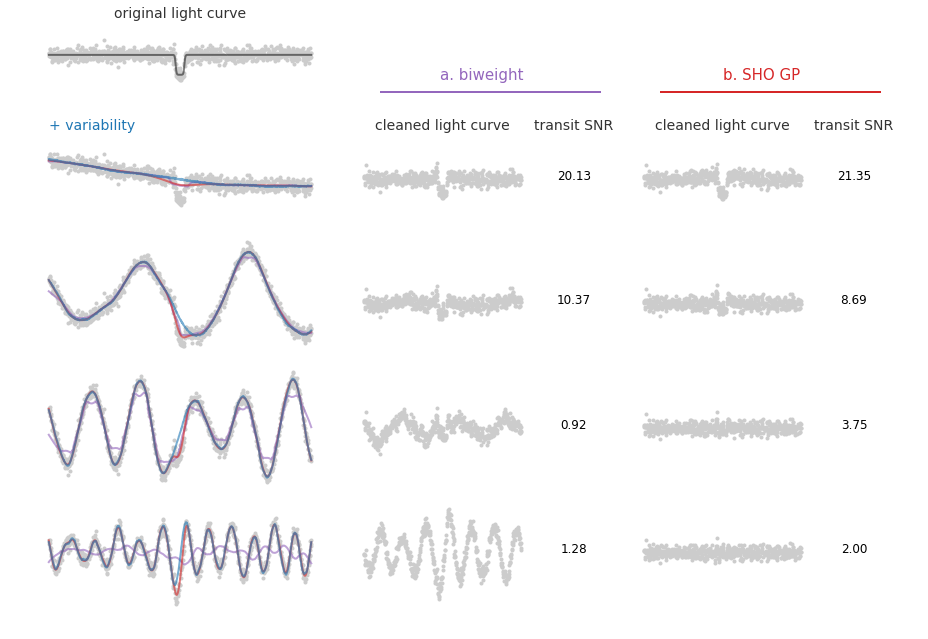

In [42]:
# Plots
# -----
offset = 0.05
plt.figure(figsize=(13,9))

wotan_color = "C4"
gp_color = "C3"

intransit = signal < (1. - depth/2)

x_wotan = 3
x_gp = 6.2

snr_offset = 0.6

for i, (flux, var, gp) in enumerate(zip(lightcurves, variabilities, gps)):
    plt.plot(time, flux - offset*i, ".", c="0.8")
    if i==0:
        plt.plot(time, signal - offset*i, c="k", alpha=0.5, lw=2)
    
    # wotan
    trend, snr = wotan_trend_snr[i]
    if i!=0:
        plt.plot(time, trend - offset*i, c=wotan_color, alpha=0.6, lw=2)
        plt.text(time[-cut] + x_wotan + snr_offset, 1 - i*offset, f"{snr:.2f}", ha="center", fontsize=12)
        plt.plot(time[cut:-cut] + x_wotan, (flux-trend)[cut:-cut] - offset*i + 1., ".", c="0.8"), 
    
    # gp
    trend, snr = gp_trend_snr[i]
    if i!=0:
        plt.plot(time, trend - offset*i, c=gp_color, alpha=0.6, lw=2)
        plt.text(time[-cut] + x_gp + snr_offset, 1 - i*offset, f"{snr:.2f}", ha="center", fontsize=12)
        plt.plot(time[cut:-cut] + x_gp, (flux-trend)[cut:-cut] - offset*i + 1., ".", c="0.8")

    if i!=0:
        plt.plot(time, var + 1 - offset*i, c="C0", alpha=0.6, lw=2)


txt_color = "0.2"
    
plt.text(time.mean(), 1.015, "original light curve", ha="center", fontsize=14, color=txt_color)
plt.text(time.min(), 1.02 - offset, "+ variability", ha="left", fontsize=14, alpha=1, c="C0")

OFFSET = 1

# wotan txt
def text(x, method, color):
    xrange = np.array([0, 2.5]) + x + 0.7
    plt.text(xrange.mean(), OFFSET-0.01, method, ha="center", fontsize=15, c=color)
    plt.plot(xrange + 0.1, (OFFSET-0.015, OFFSET-0.015), "-", c=color, lw=2)
    plt.text(time[-cut] + x + snr_offset, OFFSET-0.03, "transit SNR", ha="center", fontsize=14, c=txt_color)
    plt.text(time[cut:-cut].mean() + x, OFFSET-0.03, "cleaned light curve", ha="center", fontsize=14, c=txt_color)

text(x_wotan, "a. biweight", wotan_color)
text(x_gp, "b. SHO GP", gp_color)

plt.axis("off")
plt.tight_layout()